# Install and import libraries and Data

In [ ]:
!pip3 install torchvision==0.10.0 --quiet

     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/katelyn98/pytorch-grad-cam.git
!cd pytorch_grad_cam && pip install -r requirements.txt
!pip install requests --quiet
# !pip install grad-cam --quiet

In [ ]:
!git clone https://github.com/Gkao03/DeepGaze.git
!mv DeepGaze/deepgaze_pytorch ./
!mv DeepGaze/setup.py ./
!rm -rf DeepGaze
!wget https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy

In [ ]:
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
import os
import torch
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')  
import cv2
import numpy as np
import math
import requests
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import deepgaze_pytorch

%cd '/content/pytorch-grad-cam/'
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget

DEVICE = 'cuda'

#Data Loader

Download our trainval/test split of PASCAL2012VOC [here](https://drive.google.com/file/d/1p2ZkFiNQR0WbE28x8ukLzCUBjUy9XXM4/view?usp=sharing) and upload it to your google drive. Then copy the zip file to the Colab File System and unzip it. Be sure to change the path to original_data to match where you put it. Note: If you want to evaluate models on MIT1003 dataset, please download the images from [here](https://drive.google.com/file/d/1d9XhYXq7Wj6ANmKgvbmYDHTt0xtCGZxE/view?usp=sharing). You can also download the MIT1003 dataset [here](http://people.csail.mit.edu/tjudd/WherePeopleLook/index.html) - the images are in All Stimuli.

In [ ]:
!cp /content/drive/MyDrive/VLR_Project/data/PASCAL2012/original_data.zip /content/ && unzip /content/original_data.zip

In [ ]:
data_pth = "/content/original_data/JPEGImages/test"
mask_pth = "/content/original_data/HumanAttentionMasks/"

In [ ]:
train_transform = transforms.Compose([transforms.Resize((512, 512)), 
                                      transforms.ToTensor(),
                                      ])

class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.image_paths = []
        for file in os.listdir(image_dir):
            if file.endswith(".jpg"):
                self.image_paths.append(os.path.join(data_pth, file))

        if mask_dir is not None:
          self.mask_dir = mask_dir
          self.mask_paths = []
          for file in os.listdir(mask_dir):
              if file.endswith(".jpg"):
                  self.mask_paths.append(os.path.join(mask_pth, file))
        else:
          self.mask_dir = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        tensor = self.transform(img).unsqueeze(0)

        if self.mask_dir is not None:
          mask_path = self.mask_paths[idx]
          mask = np.array(Image.open(mask_path).convert("L"))

          mask = cv2.resize(mask, (512, 512))
        else:
          mask = None

        return img, tensor, mask, img_path
        

def collate_fn(sample):
    # only with batch size=1
    img, tensor, mask, img_path = sample[0]
    return img, tensor, mask, img_path

#for test and evaluation
train_dataset = MyDataset(image_dir=data_pth, mask_dir=mask_pth, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Helper Functions

In [ ]:
def resizer(x, res=512):  # input is np array
    # x = x.detach().cpu().numpy()
    x = cv2.resize(x, (res, res))
    rgb_img = x.copy()
    x = np.float32(x) / 255
    # transform = transforms.ToTensor()
    # tensor = transform(img).unsqueeze(0)
    return x

def normalize_data(data):  # np array input
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
def inpaint_black(attributions, img_orig, threshold = 95):
  mask = attributions <= np.percentile(attributions, threshold)
  im_mask = np.array(img_orig)
  im_mask[~mask] = 0
  return im_mask

# Metrics

In [ ]:
def calcMAE(P, Y):
    # takes two np arrays of the same shape
    assert(P.shape == Y.shape)
    W, H = P.shape
    # print("DEEPGAZE: ", P)
    # print("REGULAR: ", Y)
    abs_diff = np.abs(P - Y)
    return np.sum(abs_diff) / (W * H)

def calcIOU(a, b, percentile=90):  # default 90% threshold 
    # takes two np arrays normalized to 0-1 of same shape
    assert(a.shape == b.shape)
    a_bool = a >= np.percentile(a, percentile)
    b_bool = b >= np.percentile(b, percentile)

    overlap = a_bool & b_bool # Logical AND
    union = a_bool | b_bool # Logical OR

    IOU = overlap.sum() / float(union.sum())
    return IOU

# Deep Gaze 2

In [ ]:
# you can use DeepGazeI or DeepGazeIIE
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
deepgaze_model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

Loaded pretrained weights for efficientnet-b5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


# Faster R-CNN

In [ ]:
frcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
frcnn_model.eval().cuda()

target_layers = [frcnn_model.backbone.body.layer4] #ssd
cam = EigenCAM(frcnn_model,
               target_layers, 
               use_cuda=torch.cuda.is_available())

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# SSD

In [ ]:
ssd_model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
ssd_model.eval().cuda()

target_layers = [ssd_model.backbone.extra[1]] #ssd
cam = EigenCAM(ssd_model,
               target_layers, 
               use_cuda=torch.cuda.is_available())

# Evaluate

In [ ]:
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']

len(coco_names)

91

In [ ]:
#prediction function for SSD model
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

## Evaluate Dataset

In [ ]:
mae_deepgaze_list = []
iou_deepgaze_list = []

mae_gt_list = []
iou_gt_list = []

for batch_idx, (img, tensor, mask, img_path) in enumerate(train_loader):
    print(img_path)
    print(img_path.split("/")[-1].split(".")[0])
    # print(tensor.shape)
    img = np.array(img)
    img = cv2.resize(img, (512, 512))
    img_arr = np.float32(img) / 255
    if mask is not None:
      mask_arr = np.float32(mask) / 255
    filename = os.path.basename(img_path)
    tensor = tensor.cuda()
    ####################################
    #CHANGE THE MODEL BEING PASSED IN PREDICT TO WHAT MODEL YOU WANT TO EVALUATE!!!!
    ####################################
    boxes, classes, labels, indices = predict(tensor, frcnn_model, DEVICE, 0.9)
    targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

    grayscale_cam = cam(tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(img_arr, grayscale_cam, use_rgb=True)

    # deepgaze
    centerbias_template = np.load('centerbias_mit1003.npy')
    centerbias = zoom(centerbias_template, (img.shape[0]/centerbias_template.shape[0], img.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
    centerbias -= logsumexp(centerbias)
    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

    log_density_prediction = deepgaze_model(tensor, centerbias_tensor)
    log_density_prediction_squeezed = log_density_prediction.squeeze()
    out_deepgaze = resizer(np.exp(log_density_prediction_squeezed.detach().cpu().numpy()))
    out_deepgaze = normalize_data(out_deepgaze)

    #metrics calculation for deepgaze
    mae_deepgaze = calcMAE(out_deepgaze, grayscale_cam)
    mae_deepgaze_list.append(mae_deepgaze)

    iou_deepgaze = calcIOU(out_deepgaze, grayscale_cam)
    iou_deepgaze_list.append(iou_deepgaze)

    if mask is not None:
      #metrics calculation for ground truth
      mae_gt = calcMAE(mask, grayscale_cam)
      mae_gt_list.append(mae_gt)

      iou_gt = calcIOU(mask, grayscale_cam)
      iou_gt_list.append(iou_gt)

    print(f"file {filename} has MAE {mae_deepgaze} and IOU {iou_deepgaze} for DeepGaze. Progress {batch_idx+1}/{len(train_loader)}")
    if mask is not None:
      print(f"file {filename} has MAE {mae_gt} and IOU {iou_gt} for Ground Truth. Progress {batch_idx+1}/{len(train_loader)}")

# Graphs for Metrics

In [ ]:
mean_mae_deepgaze = sum(mae_deepgze_list) / len(mae_deepgaze_list)
print(f"mean MAE for deepgaze is {mean_mae_deepgaze}")

mean_iou_deepgaze = sum(iou_deepgze_list) / len(iou_deepgaze_list)
print(f"mean IOU for deepgaze is {mean_iou_deepgaze}")

mean_mae_gt = sum(mae_gt_list) / len(mae_gt_list)
print(f"mean MAE for human attention masks is {mean_mae_gt}")

mean_iou_gt = sum(iou_gt_list) / len(iou_gt_list)
print(f"mean IOU for human attention masks is {mean_iou_gt}")

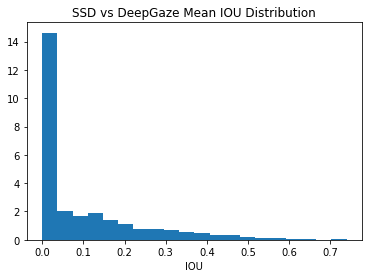

In [ ]:
plt.cla()
plt.clf()
plt.hist(mae_list, bins=20, density=True)
plt.title("Model vs DeepGaze Mean Average Error Distribution")
plt.xlabel("MAE")
plt.savefig('/content/hist.png')

plt.cla()
plt.clf()
plt.hist(iou_list, bins=20, density=True)
plt.title("Model vs DeepGaze Mean IOU Distribution")
plt.xlabel("IOU")
plt.savefig('/content/iou.png')